In [ ]:
# model code

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=9, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [26]:
# make directory & install packages
!mkdir test_image
!mkdir test_image/gt_data
!mkdir test_image/raw_data

!pip install patchify

!pip install segmentation_models

# !pip install keras==2.4.3
# !pip install tensorflow==2.4.1
!apt-get install -y libsm6 libxext6 libxrender-dev
!pip install opencv-python

���� ������ �ùٸ��� �ʽ��ϴ�.
���� ������ �ùٸ��� �ʽ��ϴ�.


  Using cached patchify-0.2.3-py3-none-any.whl (6.6 kB)


  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
     --------------------------------------- 12.1/12.1 MB 23.3 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 24.2 MB/s eta 0:00:00
  Using cached imageio-2.19.3-py3-none-any.whl (3.4 MB)
  Using cached networkx-2.8.4-py3-none-any.whl (2.0 MB)
  Using cached tifffile-2022.5.4-py3-none-any.whl (195 kB)


'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [12]:
# image dataset patching

# https://youtu.be/jvZm8REF2KY
"""
Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E
https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:
Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B
Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256
"""

import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
# from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'D:/National_Park/test_image'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'raw_data':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for image_name in (images):  
            if image_name.endswith(".tif"):   #Only read jpg images...
                image = cv2.imread(path+"/"+image_name)  #Read each image as BGR
                

                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

In [18]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
# from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'D:/National_Park/test_image'

patch_size = 256

#Now do the same as above for masks
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'gt_data':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".tif"):   #Only read png images... (masks in this dataset)
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

In [ ]:
#import pickle
#
#with open("image_dataset_pickle.pkl", "wb" ) as file:
#    pickle.dump(image_dataset, file)

In [ ]:
#import pickle
#
#with open( "mask_dataset_pickle.pkl", "wb" ) as file:
#    pickle.dump(mask_dataset, file)

In [19]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [20]:
mask_dataset.shape

(1312, 256, 256, 3)

In [16]:
image_dataset.shape

(1312, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


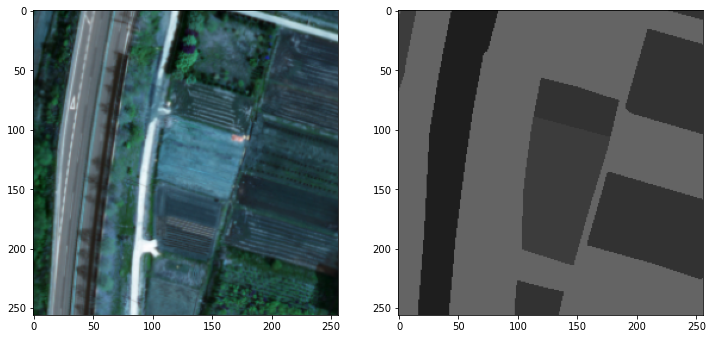

In [21]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [22]:
###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152
"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...

#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#0A0A0A'.lstrip('#') # 빌딩
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Road = '#1E1E1E'.lstrip('#') # 도로
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Parking = '#141414'.lstrip('#') # 주차장
Parking = np.array(tuple(int(Parking[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

RoadTree = '#282828'.lstrip('#') # 가로수
RoadTree = np.array(tuple(int(RoadTree[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

LicePad = '#323232'.lstrip('#') # 논
LicePad = np.array(tuple(int(LicePad[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

FarmField = '#3C3C3C'.lstrip('#') # 밭
FarmField = np.array(tuple(int(FarmField[i:i+2], 16) for i in (0, 2, 4))) #100, 100, 100

Forrest =  '#464646'.lstrip('#') # 산림
Forrest = np.array(tuple(int(Forrest[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

EmptyLand = '#505050'.lstrip('#') # 나지
EmptyLand = np.array(tuple(int(EmptyLand[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#646464'.lstrip('#') # 비대상
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer

def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==Building,axis=-1)] = 0
    label_seg [np.all(label==Road,axis=-1)] = 1
    label_seg [np.all(label==Parking,axis=-1)] = 2
    label_seg [np.all(label==RoadTree,axis=-1)] = 3
    label_seg [np.all(label==LicePad,axis=-1)] = 4
    label_seg [np.all(label==FarmField,axis=-1)] = 5
    label_seg [np.all(label==Forrest,axis=-1)] = 6
    label_seg [np.all(label==EmptyLand,axis=-1)] = 7
    label_seg [np.all(label==Unlabeled,axis=-1)] = 8

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)
        

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5 6 7 8]


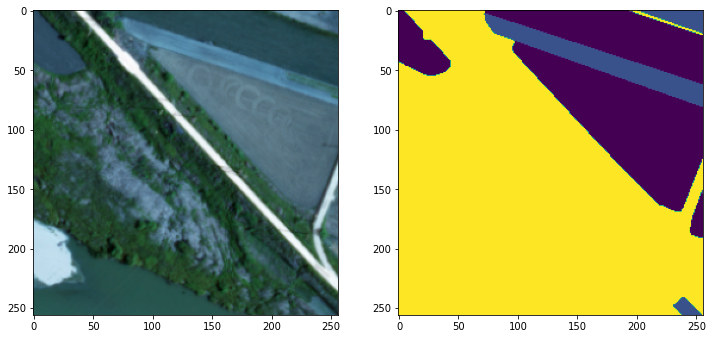

NameError: name 'multi_unet_model' is not defined

In [27]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


############################################################################


n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is: 0.62  (Mean IoU: 0.6)            
#With dice loss only, after 100 epochs val jacard is: 0.74 (Reached 0.7 in 40 epochs)
#With dice + 5 focal, after 100 epochs val jacard is: 0.711 (Mean IoU: 0.611)
##With dice + 1 focal, after 100 epochs val jacard is: 0.75 (Mean IoU: 0.62)
#Using categorical crossentropy as loss: 0.71

##With calculated weights in Dice loss.    
#With dice loss only, after 100 epochs val jacard is: 0.672 (0.52 iou)


##Standardscaler 
#Using categorical crossentropy as loss: 0.677

# model.save('models/satellite_standard_unet_100epochs_7May2021.hdf5')
############################################################
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())


history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=8, 
          epochs=10,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is:               
#With dice + 5 focal, after 100 epochs val jacard is: 0.73 (reached 0.71 in 40 epochs. So faster training but not better result. )
##With dice + 1 focal, after 100 epochs val jacard is:   
    ##Using categorical crossentropy as loss: 0.755 (100 epochs)
#With calc. weights supplied to model.fit: 
 
#Standard scaler
#Using categorical crossentropy as loss: 0.74


###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [12]:
model.save('models/unet_resnet50_airial_100epochs.hdf5')

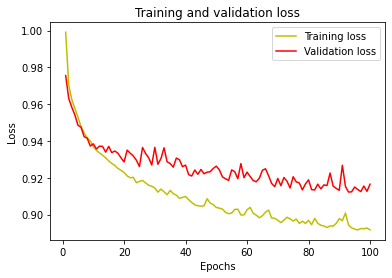

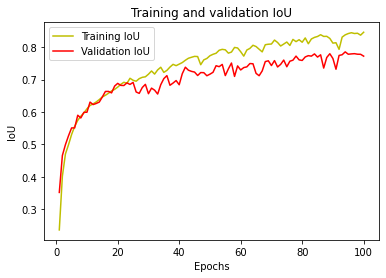

In [15]:
###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

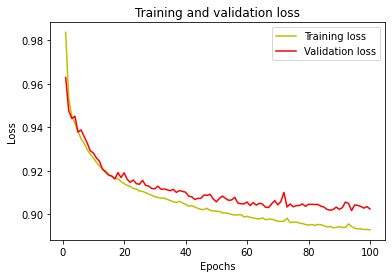

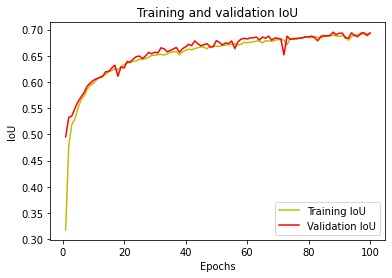

In [ ]:
###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
# model.save('models/plain_100epochs.hdf5')
# model.save('models/unet_resnet50_100epochs.hdf5')

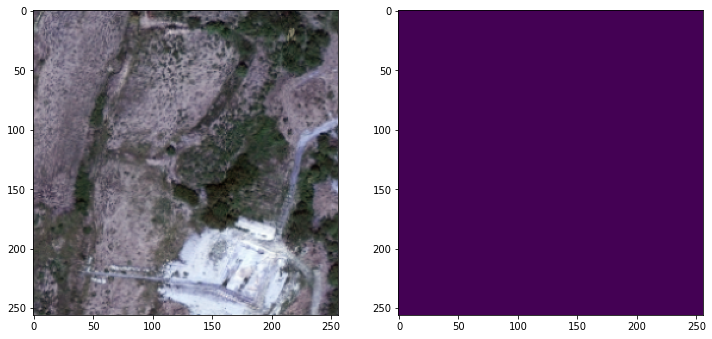

In [12]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


############################################################################


n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

In [1]:
from keras.models import load_model
model = load_model("D:/National_Park/unet_resnet50_airial_100epochs.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

NameError: name 'total_loss' is not defined

In [28]:
##################################
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

from keras.models import load_model
model = load_model("D:/National_Park/unet_resnet50_airial_100epochs.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 9
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

#####################################################################

: 

: 

In [22]:
predicted_img

array([[8, 8, 8, ..., 4, 4, 4],
       [8, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [0, 0, 0, ..., 8, 8, 8],
       [0, 0, 0, ..., 8, 8, 8],
       [0, 0, 0, ..., 8, 8, 8]])

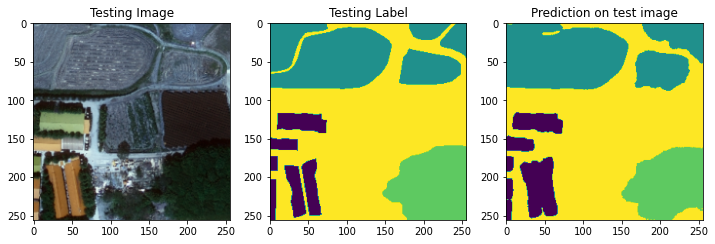

In [14]:
#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

#####################################################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


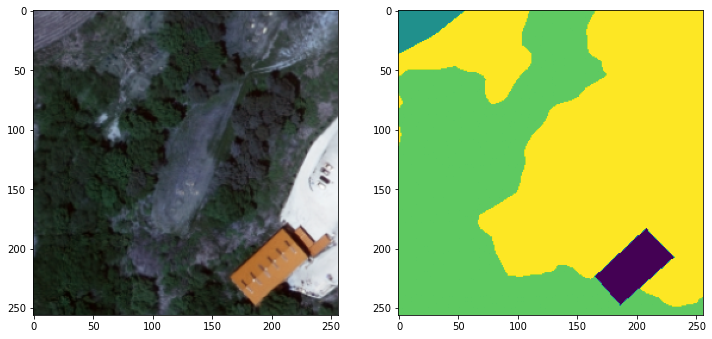

In [ ]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


############################################################################


n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Mean IoU = 0.07050398


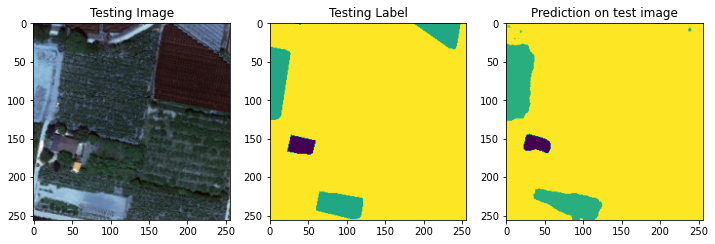

In [36]:
##################################
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

from keras.models import load_model
model = load_model("/content/models/unet_resnet50_airial_100epochs.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 9
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

#####################################################################